# Advanced Machine Learning - programming assignment 1

*Due: Friday December 1st*

**Please fill in:**
* Tijn van Heertum (6612172)
* Jaffar Husain (1209671)

### Further instructions:
* Code quality is considered during the assessment. Make sure your code is properly commented.
* Submit your code in Blackboard using **one** of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name (i.e. submitter_collaborator.ipynb).
* **Failure to follow these instructions can affect the assignment grade.**

## Multi-armed Bandits

In this programming assignment, we will look at how we can solve a k-armed bandit problem as discussed in the lecture. Expect for winning at the slot machines, you are expect to better understand the tradeoff between exploration and exploiation.

Here are the objectives of this assignment:
1.   Get familier with the Open-AI gym/gymnasium environment,
2.   Implement your own k-armed bandit environment based on the gym framework,
3.   Use an epsilon-greedy algorithm to find the optimal action for this k-armed bandit problem,
4.   Play with the parameter epsilon and identify a reasonable setting for balancing exploration and exploiation.
    

### 0. Please check the given 'README' file

### 1. Let's start with the OpenAI gym

Gym/Gymnasium (https://gymnasium.farama.org/) is a wide-used toolkit for developing and comparing reinforcement learning algorithms.

1. Gym/Gymnasium makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano.

2. The library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

**Great!** Now let's import the gym class and work on a basic example of gym code.


In [1]:
!pip install gymnasium==0.28.1
!pip install tdqm==4.65.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 9.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tdqm==4.65.0 (from versions: 0.0.0, 0.0.1)
ERROR: No matching distribution found for tdqm==4.65.0


In [1]:
import gymnasium

Like mentioned above, gym's main purpose is to provide a large collection of **environments** that expose a common interface. You can find a listing of those environments below (they are Markov decision process(MDP) environments and we will discuss MDP in our lecture 11), as follows:

In [2]:
from gymnasium import envs
print(envs.registry)

{'CartPole-v0': EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'CartPole-v1': EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'MountainCar-v0': EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_thr

We are now going to explain how the RL framework of gym works.
- An **ENVIRONMENT**,
- You also have an **AGENT**,
- The agent takes an **ACTION**, in our case, 10 actions are possible to take,
- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value.

In MDP problems, the **ENVIRONMENT** will also provides an **OBSERVATION**, which represets the state of the **ENVIRONMENT** at the current moment. In the multi-armed bandit problems, there is no **OBSERVATION** (or state). You may understand this better after the lecture about Markov decision process (MDP).

Please read the 'Basic usage' https://gymnasium.farama.org/content/basic_usage/ for better understanding the framework.


### 2. Implement your own environment

Next, we are going to implement our own environment following the framework of gym. This enviroment is a gambiling room with ten different slot machines (a 10-armed bandit problem). Similar with examples given in the lecture, the reward of each slot machine follows a normal distribution, but the average reward (mean) and variance of each action are different. Your goal is to determine the optimal action from all possible actions/machines.

The core gym interface is **Env**, which is the unified environment interface. There is no interface for agents. The following are the Env methods you should know:

- `step(self, action)`: Steps the environment by one timestep. Returns observation, reward, done, info.
- `reset(self)`: Resets the environment to an initial state. Returns an initial observation. Each call of `reset()` should yield an environment suitable for a new episode, independent of previous episodes. Because there is no state transition in multi-armed bandit problems, this function is not used here.
- `render(self, mode='human')`: Renders one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window.

Before writing your own codes, read through the readme of github page of gymasium (https://github.com/Farama-Foundation/Gymnasium). You are also recommended to read at least the codes for one simple environment and one example agent.

#### 2.1 Self-defined Slot Machine

**Please fill in the missing codes in the function sample (1 point).**

In [3]:
import numpy as np

class slotMachine:
    """
        A slot machine contains a reward distribution that randomly generated with restricted mean and standard deviation.
            sample function: generates a reward at each time step based on the given reward distribition
    """
    def __init__(self):
        self.mu = np.random.uniform(-5, 5)  # mean
        self.sigma = np.random.uniform(0.5, 1)  # standard deviation

    def sample(self):
        return np.random.normal(self.mu, self.sigma) # generates a reward from a normal distribution with mean mu and standard deviation sigma.

#### 2.2 Game Environment
**Please fill in the missing codes in function step (1 point) in the environment.**

In [5]:
from gymnasium import spaces

# The environment has to inherit the interface of gymnasium.Env
class GamblingRoom(gymnasium.Env):
    """
    A k-armed bandit environment: a gambling room with slot machines, allows the agents to interact with it.
        r_machines: A list of slot machines, each gamblingRoom contains k number of slotMachines
    """
    def __init__(self, k, seed=None):
        self.seed(seed)
        # initialize reward distribution for each action/machine
        self.r_machines = []
        for i in range(k):
            # each gamblingRoom contains k number of slotMachines
            self.r_machines.append(slotMachine())

        self.num_arms = k
        self.action_space = spaces.Discrete(self.num_arms)
        self.observation_space = spaces.Discrete(1)
        # for our bandit environment, the state is constant
        self.state = 0

    # step up the environment based on the selected action,
    # return the constant state, reward, done = false, and info
    # for now, we do not have to worry about the DONE and INFO variables.
    def step(self, action):
        assert self.action_space.contains(action)
        done = False

        reward = self.r_machines[action].sample() # Defines the reward for the current step as the sample draw from machine from the list of slotmachines corresponding to the action.

        return self.state, reward, done, {}

    # random seed used for reproducibility purposes
    def seed(self, seed):
        if seed is not None:
            np.random.seed(seed)

    def reset(self):
        pass

    def render(self, mode='human', close=False):
        pass

    def close(self):
        pass

### 3. Implement an agent with the epsilon greedy algorithm

In this part, you are expected to implement an RL agent. To decide the action to take at each time step, this agent uses the epsilon greedy algorithm introduced in the lecture.

**Please fill in the missing codes in function select_action (1.5 points) and update_parameters (1 point) in the agent.** Feel free to import the needed packages if there are any.

In [6]:
import random
from random import randrange

class EplisonGreedyAgent:
    def __init__(self, k, e):
        # set up the number of arms/actions
        self.num_arms = k
        # set up the value of epsilon
        self.epsilon = e
        # init the estimated values of all actions
        self.Qvalues = np.zeros(k)
        # init the numbers of time step that every action is selected
        self.stepSize = np.zeros(k)

    ##
    # select the action to take at the current time step
    # (for MDP, choose the action based on state; for k-armed bandit, no state given)
    # return: the action to take
    ##
    def select_action(self):
        if random.uniform(0, 1) >= self.epsilon: #if a random draw is larger than or equal to epsilon, select greedy algorithm.
            greedy_actions = np.where(self.Qvalues == np.max(self.Qvalues))[0] #select the actions that have the maximum estimated value.
            action = np.random.choice(greedy_actions) #randomly choose an action with the highest estimated value.
            exploitation_count[0] += 1 # add a counter for exploitation as a list to make it mutable.
        else:
            action = random.randrange(self.num_arms) #otherwise, select a random action from all possible actions.
            exploration_count[0] += 1 #add a counter for exploration as a list to make it mutable.

        return action
    ##
    # Update the Q-values of the agent based on received rewards
    # input: action_index = the action, reward = the reward from this action
    # return: null
    ##
    def update_parameters(self, action, reward):
        small_constant = 1e-10 # prevents dividing by 0 when stepsize is 0.
        self.Qvalues[action] += 1/(self.stepSize[action] + small_constant) * (reward - self.Qvalues[action]) #update the action index in the list of qvalues to be the new average based on Qt = Qt-1 + 1/t-1 (Rt-1 - Qt-1)
        self.stepSize[action] += 1 #Update stepsize of the action index with +1.




### 4. Run the simulation, play with parameters and analyse results

Finally, we write codes for running the simulation.

In order to decrease the effect of randomness, we usually conduct multiple simulation runs and average the results. In the implementation, you may start with one run, then use the variable `num_runs` for running multiple simulations.

In each run, you shall setup the `epsilon` and number of time step `num_episodes` (0.01 and 500 by default). Then, after the initlization of our agent and environment, **please fill in the missing codes (with ??? or TODO: to be filled). (2.5 points)**

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) #please run to silence the automatic warnings


num_action = 10
num_seed = 10000 #our choice based on testing: analysis is provided in section 5
num_runs = 500  # number of simulation runs
num_episodes = 1000  # number of steps in each run
epsilon = 0.08 #our choice based on testing: analysis is provided in section 5

# init the environment and set up the random seed
env = GamblingRoom(num_action, seed=num_seed)

# delete the wrap
env = env.unwrapped

# show the action space
print(env.action_space)

#defining the optimal action
optimal_action = np.argmax([machine.mu for machine in env.r_machines])

#create empty results variables
cumulative_rewards = []
average_reward_per_step = 0
q_values_per_run = []
action_counts = np.zeros(num_action)
exploration_count = [0] #as lists to make it mutable
exploitation_count = [0] #as lists to make it mutable
optimal_action_count = 0

#storing the rewards and optimal actions in a dataframe
my_rewards = []
df = pd.DataFrame(my_rewards)
my_optimal_actions = []
df2 = pd.DataFrame(my_optimal_actions)
optimal_actions_inventory = 0
avg_optimal = np.zeros(num_episodes)
avg_rewards = np.zeros(num_episodes)

# run multiple simulations
for i_run in range(num_runs):

    # init the epsilon-greedy RL agent
    agent = EplisonGreedyAgent(num_action, epsilon)

    #Track rewards per episode and optimal action occurance
    rewards_per_episode = []
    my_rewards = []
    my_optimal_actions = []
    optimal_actions_inventory = 0
    optimal_action_list = np.zeros(num_episodes)
    rewards_list = np.zeros(num_episodes)

    # in each simulation run, loop the action selection
    for i_episode in range (num_episodes):

        action = agent.select_action() #select action.
        reward = env.step(action)[1] #get reward for that action.
        rewards_per_episode.append(reward) #add reward to the list of rewards.
        rewards_list[i_episode] = reward
        agent.update_parameters(action, reward) #update the parameters.

        if action == optimal_action:
            optimal_action_count += 1 #add 1 to the optimal action counter if the action taken corresponds to the optimal action.
            optimal_actions_inventory += 1 #we use this counter to produce the plot
            optimal_action_list[i_episode] = 1

        my_rewards.append(np.mean(rewards_per_episode)) #average rewards per episode
        my_optimal_actions.append((optimal_actions_inventory / num_episodes)) #optimal actions per episode

    # save the result variables you need
    df.insert(i_run, i_run, my_rewards) #inventory of all average rewards per episode
    df2.insert(i_run, i_run, my_optimal_actions) #inventory of all optimal actions
    cumulative_rewards.append(np.sum(rewards_per_episode)) #sum rewards of all episodes to get cumulative rewards of that run.
    q_values_per_run.append(agent.Qvalues.copy()) #get the q_values of the end of the run for each action.
    action_counts += np.array(agent.stepSize) #add the action counts for each action.
    avg_optimal += (optimal_action_list - avg_optimal) / (i_run + 1)
    avg_rewards += (rewards_list - avg_rewards) / (i_run + 1)


summary_ave_reward_data = df.copy()
summary_ave_reward_data['average'] = summary_ave_reward_data.mean(numeric_only=True, axis=1)

summary_pct_optimal_action = df2.copy()
summary_pct_optimal_action['average'] = summary_pct_optimal_action.mean(numeric_only=True, axis=1)

optimal_action_percentage = optimal_action_count / (num_episodes*num_runs) * 100 #calculate the percentage of optimal actions taken across all runs.
average_reward_per_step = np.sum(cumulative_rewards) / (num_episodes * num_runs) #  num_episodes * num_runs calculate the average reward per step across all runs.

#print the variables:

print("Cumulative rewards:", cumulative_rewards)
print("Q Values per run:", q_values_per_run)
print("Action counts:", action_counts)
print("Exploration count:", exploration_count[0])
print("Exploitation count:", exploitation_count[0])
print("Optimal action percentage:", optimal_action_percentage)
print("Average reward per step:", average_reward_per_step)
print("List of average optimal action fraction:", avg_optimal)
print("list of average rewards:", avg_rewards)

env.close()


Discrete(10)
Cumulative rewards: [4564.827561453594, 4589.419591037011, 4553.528139159664, 4256.890884235646, 4546.771310379267, 4393.277675695624, 4394.922087535588, 4372.918515195486, 4546.87603281731, 4624.730962803027, 4615.107897938726, 4640.477634710596, 4617.809794368747, 4469.7699473216735, 4406.838798247589, 4561.334353635111, 4438.18095495317, 4637.848071139319, 4663.914478548303, 4580.035919172634, 4546.9814566662535, 4550.237830457832, 4481.614869286801, 4626.512759958259, 4500.732038681894, 4574.806472252837, 4553.99758237215, 4463.471415695036, 4593.880057840834, 4513.328997661471, 4375.727817091203, 4412.709730235021, 4497.576300511626, 4452.925725853544, 4382.506447078842, 4469.4338209136795, 4434.301082653456, 4500.985282329057, 4607.434165248303, 4615.548667547617, 4455.857094717337, 4552.600829949937, 4335.52844850442, 4358.331960528782, 4480.00967349389, 4433.288965150037, 4314.261194286728, 4567.981254961012, 4273.72071026363, 4602.488839118548, 4534.945873734427, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


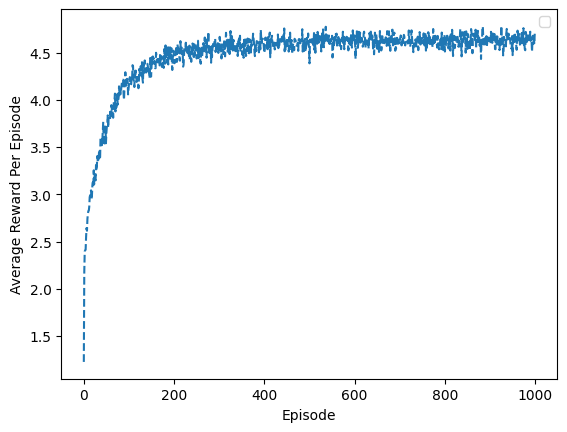

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


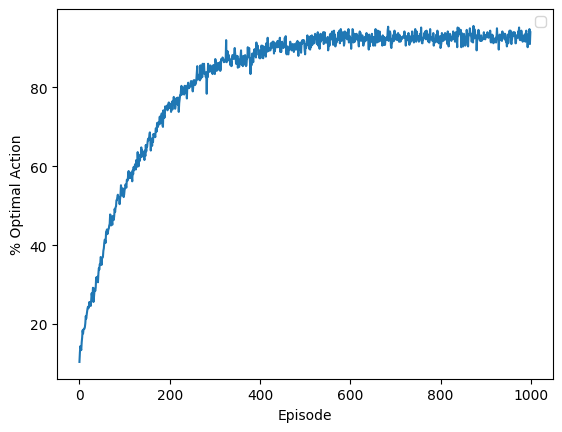

In [30]:
plt.plot(avg_rewards, linestyle="--")
plt.legend()
plt.ylabel('Average Reward Per Episode')
plt.xlabel('Episode')
plt.show()

plt.plot(avg_optimal*100, linestyle="-")
plt.legend()
plt.ylabel('% Optimal Action')
plt.xlabel('Episode')
plt.show()

### 5. Parameter testing and analysis results

In the below, we do the following:


1.   Use a function (bandit) to test different values of epsilon and seed numbers. We simulate the results across different seed values and for each seed value, we run multiple options of epsilon. We averaged the results over 1000 runs and 1000 steps.
2.   After selecting the combination of epsilon and seed value which we found to be effective, we produce the results of the simulations including a plot of the average rewards per episode and optimal action percentage. All these results can be reproduced.



### 5.1 The Bandit Function

In [37]:
#building the environment into a function for ease of use

def bandit(epsilon, seed, runs, episodes):
  num_action = 10
  num_seed = seed
  num_runs = runs  # number of simulation runs
  num_episodes = episodes  # number of steps in each run
  epsilon = epsilon

# init the environment and set up the random seed
  env = GamblingRoom(num_action, seed=num_seed)

# delete the wrap
  env = env.unwrapped

# show the action space
  #print(env.action_space)

#defining the optimal action
  optimal_action = np.argmax([machine.mu for machine in env.r_machines])

#create empty results variables
  cumulative_rewards = []
  average_reward_per_step = 0
  q_values_per_run = []
  action_counts = np.zeros(num_action)
  exploration_count = [0] #as lists to make it mutable
  exploitation_count = [0] #as lists to make it mutable
  optimal_action_count = 0
  my_rewards = []
  df = pd.DataFrame(my_rewards)
  my_optimal_actions = []
  df2 = pd.DataFrame(my_optimal_actions)
  optimal_actions_inventory = 0
  avg_optimal = np.zeros(num_episodes)
  avg_rewards = np.zeros(num_episodes)


#storing the rewards and optimal actions in a dataframe
  my_rewards = []
  df = pd.DataFrame(my_rewards)
  my_optimal_actions = []
  df2 = pd.DataFrame(my_optimal_actions)
  optimal_actions_inventory = 0
  avg_optimal = np.zeros(num_episodes)
  avg_rewards = np.zeros(num_episodes)

# run multiple simulations
  for i_run in range(num_runs):
    # init the epsilon-greedy RL agent
    agent = EplisonGreedyAgent(num_action, epsilon)

    #Track rewards per episode and optimal action occurance
    rewards_per_episode = []
    my_rewards = []
    my_optimal_actions = []
    optimal_actions_inventory = 0
    optimal_action_list = np.zeros(num_episodes)
    rewards_list = np.zeros(num_episodes)

    # in each simulation run, loop the action selection
    for i_episode in range (num_episodes):

        action = agent.select_action() #select action.
        reward = env.step(action)[1] #get reward for that action.
        rewards_list[i_episode] = reward
        rewards_per_episode.append(reward) #add reward to the list of rewards.
        agent.update_parameters(action, reward) #update the parameters.

        if action == optimal_action:
            optimal_action_count += 1 #add 1 to the optimal action counter if the action taken corresponds to the optimal action.
            optimal_actions_inventory += 1 #we use this counter to produce the plot
            optimal_action_list[i_episode] = 1

        my_rewards.append(np.mean(rewards_per_episode)) #average rewards per episode
        my_optimal_actions.append((optimal_actions_inventory / num_episodes)) #optimal actions per episode


    # save the result variables you need
    df.insert(i_run, i_run, my_rewards) #inventory of all average rewards per episode
    df2.insert(i_run, i_run, my_optimal_actions) #inventory of all optimal actions
    cumulative_rewards.append(np.sum(rewards_per_episode)) #sum rewards of all episodes to get cumulative rewards of that run.
    q_values_per_run.append(agent.Qvalues.copy()) #get the q_values of the end of the run for each action.
    action_counts += np.array(agent.stepSize) #add the action counts for each action.
    avg_optimal += (optimal_action_list - avg_optimal) / (i_run + 1)
    avg_rewards += (rewards_list - avg_rewards) / (i_run + 1)

  summary_ave_reward_data = df.copy()
  summary_ave_reward_data['average'] = summary_ave_reward_data.mean(numeric_only=True, axis=1)

  summary_pct_optimal_action = df2.copy()
  summary_pct_optimal_action['average'] = summary_pct_optimal_action.mean(numeric_only=True, axis=1)

  optimal_action_percentage = optimal_action_count / (num_episodes*num_runs) * 100 #calculate the percentage of optimal actions taken across all runs.
  average_reward_per_step = np.sum(cumulative_rewards) / (num_episodes * num_runs) #  num_episodes * num_runs calculate the average reward per step across all runs.

  #print the variables:

  #print("Cumulative rewards:", cumulative_rewards)
  #print("Q Values per run:", q_values_per_run)
  #print("Action counts:", action_counts)
  #print("Exploration count:", exploration_count[0])
  #print("Exploitation count:", exploitation_count[0])
  #print("Optimal action percentage:", optimal_action_percentage)
  #print("Average reward per step:", average_reward_per_step)
  env.close()

  return action_counts, exploration_count[0], exploitation_count[0], average_reward_per_step, optimal_action_percentage, summary_ave_reward_data, summary_pct_optimal_action, avg_rewards, avg_optimal

### 5.2 Parameter Selection:
We tested different values of epsilon and seed values. We produced the average rewards per step and optimal action percentage for each combination of epsilon and seed values. Based on the results, we chose an epsilon of 0.08 and a seed value of 10000.

In [12]:
#Please don't run this unless you have a GPU. The results are shown below

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) #please run to silence the automatic warnings

epsilon_no = [0.00, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15]
seed_no = [5, 1000, 10000]

for i_seed in seed_no:
  for i_eps in epsilon_no:
    a, b, c, d, e, f, g, h, i = bandit(epsilon=i_eps, seed=i_seed, runs=1000, episodes=1000)
    print(["seed= " f"{i_seed:0.1f}", "Epsilon= " f"{i_eps:0.2f}", "average_reward = " f"{d:0.2f}", "optimal_action_percentage = " f"{e:0.2f}"])
    Output = ["%.1f" % elem for elem in a]
    print("action count: ", Output)
    print()

['seed= 5.0', 'Epsilon= 0.00', 'average_reward = 2.59', 'optimal_action_percentage = 34.38']
action count:  ['255.0', '235.0', '2056.0', '329498.0', '246.0', '255.0', '301.0', '343820.0', '287.0', '323047.0']

['seed= 5.0', 'Epsilon= 0.01', 'average_reward = 3.05', 'optimal_action_percentage = 55.39']
action count:  ['1234.0', '1242.0', '2707.0', '288473.0', '1253.0', '1188.0', '1409.0', '553915.0', '1333.0', '147246.0']

['seed= 5.0', 'Epsilon= 0.03', 'average_reward = 3.33', 'optimal_action_percentage = 75.56']
action count:  ['3218.0', '3277.0', '4705.0', '161056.0', '3233.0', '3197.0', '3419.0', '755644.0', '3305.0', '58946.0']

['seed= 5.0', 'Epsilon= 0.05', 'average_reward = 3.36', 'optimal_action_percentage = 81.34']
action count:  ['5209.0', '5277.0', '6493.0', '108655.0', '5222.0', '5152.0', '5417.0', '813362.0', '5404.0', '39809.0']

['seed= 5.0', 'Epsilon= 0.08', 'average_reward = 3.32', 'optimal_action_percentage = 84.70']
action count:  ['8296.0', '8131.0', '9081.0', '6604

### 5.3 Producing Average Measures and Plots
Based on the results above, we choose an epsilon of 0.08 and a seed value of 10000. This choice of epsilon and seed value provides the most ideal results for the average reward (4.49) and % optimal action (82.53).  In this environment, the action count is as follows:

['11075.0', '21026.0', '14118.0', '11460.0', '825265.0', '9824.0', '8127.0', '27840.0', '8187.0', '63078.0']

In [41]:
#Applying Epsilon of 0.0, 0.01, and 0.08 and a seed value of 10000 to generate the relevant metrics and figures for comparison.

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) #please run to silence the automatic warnings

a, b, c, d, e, f, g, h, i = bandit(epsilon=0.0, seed=10000, runs=500, episodes=1000)
a1, b1, c1, d1, e1, f1, g1, h1, i1 = bandit(epsilon=0.01, seed=10000, runs=500, episodes=1000)
a2, b2, c2, d2, e2, f2, g2, h2, i2 = bandit(epsilon=0.08, seed=10000, runs=500, episodes=1000)

In [43]:
print(["average_reward = " f"{d2:0.2f}", "optimal_action_percentage = " f"{e2:0.2f}"])
Output = ["%.1f" % elem for elem in a2]
print("action count: ", Output)
print()

['average_reward = 4.49', 'optimal_action_percentage = 81.98']
action count:  ['5881.0', '10713.0', '6536.0', '6019.0', '409904.0', '5063.0', '4021.0', '13151.0', '3996.0', '34716.0']



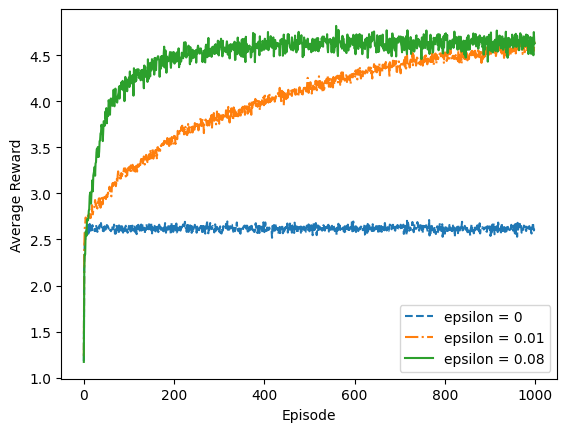

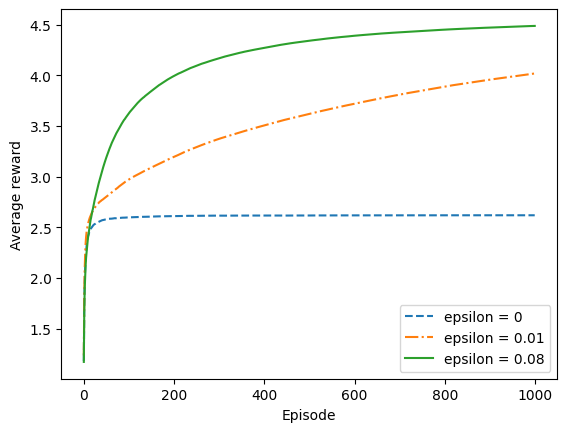

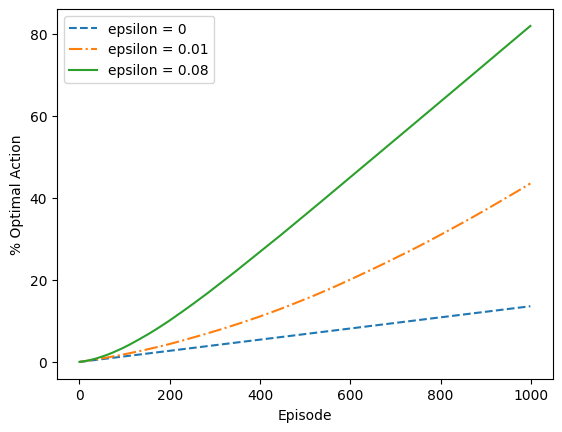

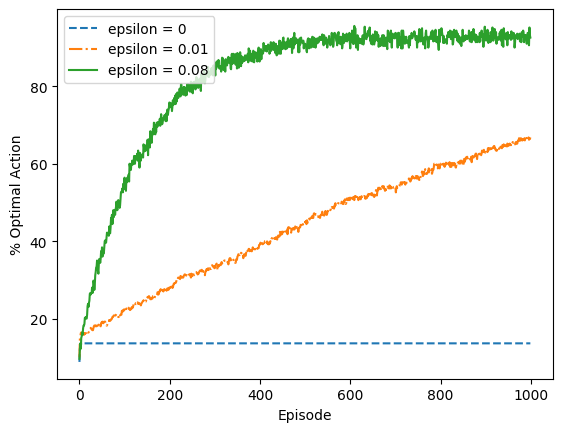

In [48]:
plt.plot(h, label='epsilon = 0', linestyle="--")
plt.plot(h1, label='epsilon = 0.01', linestyle="-.")
plt.plot(h2, label='epsilon = 0.08', linestyle="-")
plt.legend()
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.show()

plt.plot(f['average'], label='epsilon = 0', linestyle="--")
plt.plot(f1['average'], label='epsilon = 0.01', linestyle="-.")
plt.plot(f2['average'], label='epsilon = 0.08', linestyle="-")
plt.legend()
plt.ylabel('Average reward')
plt.xlabel('Episode')
plt.show()

plt.plot(g['average'] *100, label='epsilon = 0', linestyle="--")
plt.plot(g1['average']*100, label='epsilon = 0.01', linestyle="-.")
plt.plot(g2['average']*100, label='epsilon = 0.08', linestyle="-")
plt.legend()
plt.ylabel('% Optimal Action')
plt.xlabel('Episode')
plt.show()

plt.plot(i *100, label='epsilon = 0', linestyle="--")
plt.plot(i1*100, label='epsilon = 0.01', linestyle="-.")
plt.plot(i2*100, label='epsilon = 0.08', linestyle="-")
plt.legend()
plt.ylabel('% Optimal Action')
plt.xlabel('Episode')
plt.show()

Now it's time to examine the performance of algorithms with different epsilon values (different exploration strategies) in multiple simulation runs.

You shall play with the parameter epsilon under 2 or 3 different gambling environments (by initlizing different reward distributions for machines). **For each environment, try at least 2 different values of epsilon and identify a reasonable epsilon value that could balance the exploration and exploiation**. Instead of handing in your codes for this part, please select one environment you have tested and describe your environment and experimental settings **(1 point)**. Then, provide an explanation on how you identify the good epsilon value in this environment and why it is a good one **(1 point)**.

Few instructions:
- Your answer shall include two plots presenting compariable measures of the different epsilon settings (e.g. the average reward per step and % of optimal action). **(1 point)**
- You shall present the average results from at least 100 simulation runs. Remember that the gambling environment CANNOT be changed over those runs used for calculating the average results.
- You may adjust the total time steps when the learning needs more time for a cerain epsilon value, but do not over spend your time on this.    

**Put your answer (at most 300 words) with accompanying plots here.**

You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.** Please make sure that you submit a .zip file with images.

Again, make sure you name this file according to your last names.